# Sentiment Analysis Capres–Cawapres: ML with Regression and Naive Bayes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Notebook ini menyajikan pipeline **lengkap** untuk analisis sentimen teks (Bahasa Indonesia) dari dataset Twitter.
Kita akan melalui tahapan **Deep Learning Lifecycle**:
1) **Problem framing** & setup  
2) **Data loading & EDA ringan**  
3) **Data cleaning & label normalization**  
4) **Feature Engineering (TF-IDF + n-gram)** (aris mulai dari sini)
5) **Step: Classical Machine Learning Model Comparison**  
6) **Visualisasi: Confusion Matrix (NB & LR)**
7) **Final Model & Saving Artifacts (for Inference)**
8) **Inference Demo (Load Artifacts & Predict)**
  


## 0. Setup

In [2]:
# Komentar: Import library dan set seed agar hasil reprodusibel
import os, re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Optional: cek versi TensorFlow (wajib untuk train)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 1. Load Data & EDA ringkas

In [3]:
# Komentar: Baca CSV, deteksi kolom teks & label, lihat distribusi kelas
DATA_PATH = "/content/drive/MyDrive/Proyek/Data/tweet.csv"
df = pd.read_csv(DATA_PATH, encoding="utf-8", on_bad_lines="skip", low_memory=False)
text_col = 'tweet' if 'tweet' in df.columns else df.select_dtypes(include='object').columns[0]
label_col = 'sentimen' if 'sentimen' in df.columns else None
display(df.head())
print("Kolom teks:", text_col, "| Kolom label:", label_col)
if label_col:
    print(df[label_col].value_counts())

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


Kolom teks: tweet | Kolom label: sentimen
sentimen
positif    612
netral     607
negatif    596
Name: count, dtype: int64


## 2. Data Cleaning & Label Normalization

In [4]:
# Komentar: Bersihkan URL/mention/emoji, lowercasing; normalisasi label ke 3 kelas
import re
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
EMOJI_RE = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
MENTION_RE = re.compile(r"@\w+")

def clean_text(s):
    if not isinstance(s, str): return ""
    s = s.strip()
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    s = s.replace("#", " ")
    s = EMOJI_RE.sub(" ", s)
    s = re.sub(r"[^0-9a-zA-ZÀ-ÿ\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

def normalize_label(x):
    if not isinstance(x, str): return "neutral"
    xl = x.strip().lower()
    mapping = {
        "pos":"positive","positif":"positive","positive":"positive",
        "neg":"negative","negatif":"negative","negative":"negative",
        "neu":"neutral","netral":"neutral","neutral":"neutral"
    }
    return mapping.get(xl, xl if xl in {"positive","negative","neutral"} else "neutral")

df = df.copy()
df["text"] = df[text_col].astype(str).map(clean_text)
df["label"] = df[label_col].astype(str).map(normalize_label)
df[["text","label"]].head()

,text,label
0,kata indonesia tidak dihargai bangsa asing ber...,negative
1,batuan langka tasbih jokowi hadiah dari habib ...,neutral
2,di era jokowi ekonomi indonesia semakin baik 0...,neutral
3,bagi sumatera selatan asian games berdampak pd...,positive
4,negara kita ngutang buat bngun infrastruktur y...,negative


In [5]:
df["label"].value_counts()

,count
label,
positive,612
neutral,607
negative,596


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords

In [7]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_id = list(set(stopwords.words('indonesian')))

## 3. Split Data (Train/Val/Test)

In [8]:
# Komentar: Stratified split 70/15/15
from sklearn.model_selection import train_test_split
label_to_id = {"negative":0, "neutral":1, "positive":2}
id_to_label = {v:k for k,v in label_to_id.items()}

X = df["text"].values
y = np.array([label_to_id.get(v,1) for v in df["label"].values], dtype=np.int32)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(len(X_train), len(X_val), len(X_test))

1270 272 273


In [9]:
vectorizer = CountVectorizer(stop_words=stopword_id)
X_train_vector=vectorizer.fit_transform(X_train)
X_train_vector.shape

NameError: name 'stopword_id' is not defined

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopword_id = list(set(stopwords.words('indonesian')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=stopword_id)
X_train_vector=vectorizer.fit_transform(X_train)
X_train_vector.shape

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


(1270, 5571)

In [12]:
X_train_array = X_train_vector.toarray()
df = pd.DataFrame(data=X_train_array, columns = vectorizer.get_feature_names_out()) # untuk scikit learn baru, menggunakan get_feature_names()
df

,000,01,01indonesiamaju,01jokowiamin,01ndonesiamaju,01optimisindonesiamaju,02,02menangdebat,02menangradikalorbaasengberkuasa,02tunggangiislam,...,ziarah,zippo,zk7rklfe13,zon,zonk,zp5i6idv9d,zpno3e1eo2,zswykszpbu,ztf4kwjtgj,zy2ggj93fp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_test_vector=vectorizer.transform(X_test)
X_test_vector.shape

(273, 5571)

In [14]:
X_val_vector=vectorizer.transform(X_val)
X_val_vector.shape

(272, 5571)

## 4. Feature Engineering (TF-IDF + n-gram)

Pada tahap ini kita mengubah teks menjadi representasi numerik menggunakan **TF-IDF**.  
- Menggunakan **unigram + bigram** (`ngram_range=(1,2)`) agar konteks pasangan kata juga tertangkap.  
- `min_df=2` → hanya ambil kata/phrase yang muncul minimal di 2 dokumen.  
- `max_df=0.95` → buang kata/phrase yang terlalu umum (muncul di >95% dokumen).  
- `max_features=30000` → batasi ukuran vocab agar tidak terlalu besar.  

Output akan berupa matriks sparse yang siap dipakai pada model klasik (Naive Bayes, Logistic Regression, SVM, dll).


In [15]:
# Step 4: Feature Engineering (TF-IDF + n-gram)
from sklearn.feature_extraction.text import TfidfVectorizer

# Konfigurasi TF-IDF
tfidf = TfidfVectorizer(
    max_features=30000,     # batas vocab
    ngram_range=(1,2),      # unigram + bigram
    min_df=2,               # hanya kata yang muncul >= 2 dokumen
    max_df=0.95             # buang kata terlalu umum
)

# Fit ke data training dan transform semua dataset
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (val):  ", X_val_tfidf.shape)
print("TF-IDF shape (test): ", X_test_tfidf.shape)


TF-IDF shape (train): (1270, 5097)
TF-IDF shape (val):   (272, 5097)
TF-IDF shape (test):  (273, 5097)


## 5. Model Comparison: Naive Bayes vs Logistic Regression

Pada tahap ini kita membandingkan performa dua model klasik berbasis TF-IDF features:

- **Multinomial Naive Bayes** → cepat, cocok untuk teks dengan representasi BoW/TF-IDF.  
- **Logistic Regression** → baseline kuat untuk klasifikasi teks.  

Kita akan evaluasi dengan akurasi dan classification report.


In [16]:
# Step 5: Model Comparison: Naive Bayes vs Logistic Regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Model 1: Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_val_tfidf)

print("=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print(classification_report(y_val, y_pred_nb))

# Model 2: Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_val_tfidf)

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr))


=== Naive Bayes ===
Accuracy: 0.5882352941176471
              precision    recall  f1-score   support

           0       0.58      0.69      0.63        89
           1       0.65      0.57      0.61        91
           2       0.55      0.51      0.53        92

    accuracy                           0.59       272
   macro avg       0.59      0.59      0.59       272
weighted avg       0.59      0.59      0.59       272


=== Logistic Regression ===
Accuracy: 0.5698529411764706
              precision    recall  f1-score   support

           0       0.54      0.69      0.60        89
           1       0.60      0.58      0.59        91
           2       0.58      0.45      0.50        92

    accuracy                           0.57       272
   macro avg       0.57      0.57      0.57       272
weighted avg       0.57      0.57      0.57       272



## 6. Visualisasi: Confusion Matrix (NB & LR)

Kita menampilkan **confusion matrix** untuk kedua model (Naive Bayes dan Logistic Regression) pada **validation set**.  
- Gunakan `normalize='true'` untuk melihat proporsi (opsional).  
- Gambar juga disimpan sebagai PNG di folder `./outputs` agar mudah dimasukkan ke README/Notion.

Catatan:
- Jika label adalah teks (multi-kelas), nama kelas akan otomatis terbaca dari `y_val`.
- Semakin terang diagonal utama → semakin baik akurasi per kelas.


<Figure size 600x500 with 0 Axes>

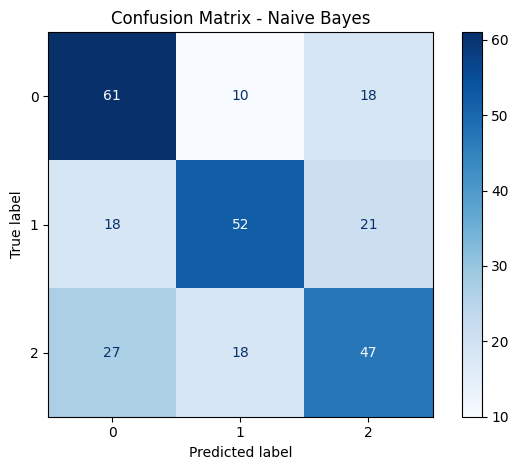

Saved: ./outputs/confusion_matrix_nb.png


<Figure size 600x500 with 0 Axes>

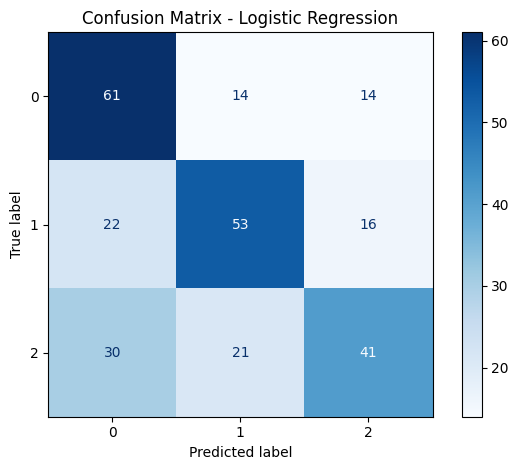

Saved: ./outputs/confusion_matrix_lr.png


In [17]:
# Step 6: Visualisasi Confusion Matrix
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pastikan model & prediksi Step 5 sudah ada:
#   - nb, y_pred_nb
#   - lr, y_pred_lr
#   - y_val

# Siapkan label/nama kelas
classes = np.unique(y_val)

# Folder output untuk menyimpan gambar
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def plot_and_save_cm(y_true, y_pred, classes, title, save_path, normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=classes, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(6, 5))
    disp.plot(values_format=".2f" if normalize else "d", cmap="Blues", colorbar=True)
    plt.title(title + ("" if not normalize else " (Normalized)"))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()
    print(f"Saved: {save_path}")

# === Naive Bayes ===
plot_and_save_cm(
    y_true=y_val,
    y_pred=y_pred_nb,
    classes=classes,
    title="Confusion Matrix - Naive Bayes",
    save_path=os.path.join(OUTPUT_DIR, "confusion_matrix_nb.png"),
    normalize=None  # ganti ke 'true' jika mau proporsi
)

# Versi normalized (opsional, aktifkan jika perlu)
# plot_and_save_cm(
#     y_true=y_val,
#     y_pred=y_pred_nb,
#     classes=classes,
#     title="Confusion Matrix - Naive Bayes",
#     save_path=os.path.join(OUTPUT_DIR, "confusion_matrix_nb_normalized.png"),
#     normalize='true'
# )

# === Logistic Regression ===
plot_and_save_cm(
    y_true=y_val,
    y_pred=y_pred_lr,
    classes=classes,
    title="Confusion Matrix - Logistic Regression",
    save_path=os.path.join(OUTPUT_DIR, "confusion_matrix_lr.png"),
    normalize=None
)

# Versi normalized (opsional)
# plot_and_save_cm(
#     y_true=y_val,
#     y_pred=y_pred_lr,
#     classes=classes,
#     title="Confusion Matrix - Logistic Regression",
#     save_path=os.path.join(OUTPUT_DIR, "confusion_matrix_lr_normalized.png"),
#     normalize='true'
# )


## 7. Final Model & Saving Artifacts (for Inference)

Pada tahap ini:
1) Pilih **model terbaik** berdasarkan akurasi validasi (dari Step 5).
2) **Refit** ulang model terbaik pada gabungan **train+val** agar model memanfaatkan lebih banyak data.
3) **Refit** juga TF-IDF pada gabungan teks **train+val** (menggunakan konfigurasi yang sama).
4) **Simpan artefak** (vectorizer & model) sebagai file `.joblib` untuk inference ke depannya.
5) Sediakan **helper function** untuk inference cepat (memuat vectorizer & model, lalu prediksi).

Catatan:
- Artefak disimpan ke folder `./artifacts`. Jika Google Drive ter-mount, artefak juga disalin ke `/content/drive/My Drive/Proyek/OutputSentimentNew/artifacts` (ubah jika perlu).
- Menjaga konsistensi, kita **refit TF-IDF** di gabungan train+val sehingga vocabulary mencakup konteks yang lebih luas sebelum deployment.


In [18]:
# Step 7: Final Model + Save Artifacts (Vectorizer & Model)
import os
import joblib
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# ==== 7.1 Pilih model terbaik dari Step 5 (pakai akurasi validasi) ====
acc_nb = accuracy_score(y_val, y_pred_nb)
acc_lr = accuracy_score(y_val, y_pred_lr)

best_name = "NaiveBayes" if acc_nb >= acc_lr else "LogisticRegression"
print(f"Validation Accuracy - NB: {acc_nb:.4f} | LR: {acc_lr:.4f} --> Best: {best_name}")

# ==== 7.2 Refit TF-IDF & Model pada gabungan train + val ====
# Gabungkan teks & label
texts_trainval = list(X_train) + list(X_val)
y_trainval = np.concatenate([y_train, y_val])

# Gunakan konfigurasi TF-IDF yang SAMA dengan Step 4
tfidf_final = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)

X_trainval_tfidf = tfidf_final.fit_transform(texts_trainval)
X_test_tfidf_final = tfidf_final.transform(X_test)

# Instansiasi ulang model terbaik & fit pada train+val
if best_name == "NaiveBayes":
    from sklearn.naive_bayes import MultinomialNB
    best_model_final = MultinomialNB()
else:
    from sklearn.linear_model import LogisticRegression
    best_model_final = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)

best_model_final.fit(X_trainval_tfidf, y_trainval)

# ==== 7.3 (Opsional) Evaluasi akhir pada Test Set ====
y_test_pred = best_model_final.predict(X_test_tfidf_final)
acc_test = accuracy_score(y_test, y_test_pred)
print("\n=== Final Model on TEST ===")
print("Accuracy:", acc_test)
print(classification_report(y_test, y_test_pred))

# ==== 7.4 Simpan Artefak ====
# Buat folder lokal
ARTIFACT_DIR = "./artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Timestamp agar versi file unik
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
vec_path_local = os.path.join(ARTIFACT_DIR, f"tfidf_vectorizer_{best_name}_{ts}.joblib")
mdl_path_local = os.path.join(ARTIFACT_DIR, f"model_{best_name}_{ts}.joblib")

joblib.dump(tfidf_final, vec_path_local)
joblib.dump(best_model_final, mdl_path_local)
print(f"\nSaved local artifacts:\n- {vec_path_local}\n- {mdl_path_local}")

# Jika Google Drive ter-mount, salin ke drive
drive_root = "/content/drive/My Drive/Proyek/OutputSentimentNew/artifacts"
if os.path.exists("/content/drive"):
    os.makedirs(drive_root, exist_ok=True)
    vec_path_drive = os.path.join(drive_root, os.path.basename(vec_path_local))
    mdl_path_drive = os.path.join(drive_root, os.path.basename(mdl_path_local))
    import shutil
    shutil.copy(vec_path_local, vec_path_drive)
    shutil.copy(mdl_path_local, mdl_path_drive)
    print(f"\nCopied to Google Drive:\n- {vec_path_drive}\n- {mdl_path_drive}")
else:
    print("\nGoogle Drive not mounted. Skipping Drive copy.")

# ==== 7.5 Helper: Inference function ====
def load_artifacts(vectorizer_path, model_path):
    """Load TF-IDF vectorizer & trained model from disk."""
    vec = joblib.load(vectorizer_path)
    mdl = joblib.load(model_path)
    return vec, mdl

def predict_texts(texts, vectorizer, model, return_proba=True):
    """Predict labels (and optional probabilities if available) for a list of texts."""
    X = vectorizer.transform(texts)
    y_pred = model.predict(X)
    result = {"y_pred": y_pred}
    # Not all models have predict_proba
    if return_proba and hasattr(model, "predict_proba"):
        result["y_proba"] = model.predict_proba(X)
    return result

print("\nHelper functions `load_artifacts` & `predict_texts` are ready.")
print("Usage example:")
print(f"vec, mdl = load_artifacts('{vec_path_local}', '{mdl_path_local}')")
print("res = predict_texts(['contoh kalimat uji'], vec, mdl)")
print("res['y_pred'], res.get('y_proba')")


Validation Accuracy - NB: 0.5882 | LR: 0.5699 --> Best: NaiveBayes

=== Final Model on TEST ===
Accuracy: 0.6336996336996337
              precision    recall  f1-score   support

           0       0.59      0.74      0.66        90
           1       0.71      0.55      0.62        91
           2       0.62      0.61      0.62        92

    accuracy                           0.63       273
   macro avg       0.64      0.63      0.63       273
weighted avg       0.64      0.63      0.63       273


Saved local artifacts:
- ./artifacts/tfidf_vectorizer_NaiveBayes_20251003_150729.joblib
- ./artifacts/model_NaiveBayes_20251003_150729.joblib

Copied to Google Drive:
- /content/drive/My Drive/Proyek/OutputSentimentNew/artifacts/tfidf_vectorizer_NaiveBayes_20251003_150729.joblib
- /content/drive/My Drive/Proyek/OutputSentimentNew/artifacts/model_NaiveBayes_20251003_150729.joblib

Helper functions `load_artifacts` & `predict_texts` are ready.
Usage example:
vec, mdl = load_artifacts('./art

## 8. Inference Demo (Load Artifacts & Predict)

Di tahap ini kita:
1) Memuat **artefak terbaru** (vectorizer & model) dari folder `./artifacts`.
2) Menjalankan prediksi dari:
   - **List** teks langsung
   - **CSV** (kolom wajib: `text`)

Contoh input (Bahasa Indonesia):
- **Negatif:** "Layanannya lambat banget dan sering error, saya kecewa."
- **Positif:** "Aplikasinya sangat membantu, fiturnya lengkap dan mudah dipakai!"
- **Netral:** "Saya baru mencoba sebentar, masih perlu waktu untuk menilai."

Output:
- Label prediksi (dan probabilitas jika model menyediakan `predict_proba`).
- Untuk CSV, hasil disimpan sebagai `./outputs/predictions.csv`.


In [19]:
# Step 8: Inference Demo
import os
import re
import glob
import joblib
import pandas as pd
from pathlib import Path

# === 8.1 Helper: ambil artefak "terbaru" dari ./artifacts ===
ARTIFACT_DIR = "./artifacts"

def get_latest_artifact(pattern: str):
    """Return the latest file path in ARTIFACT_DIR that matches a given pattern."""
    paths = sorted(glob.glob(os.path.join(ARTIFACT_DIR, pattern)))
    if not paths:
        raise FileNotFoundError(f"Tidak ditemukan artefak dengan pola: {pattern}")
    return paths[-1]  # ambil yang paling akhir (diasumsikan timestamp di nama file)

# Cari vectorizer & model terbaru (nama file dari Step 7)
latest_vec = get_latest_artifact("tfidf_vectorizer_*.joblib")
latest_mdl = get_latest_artifact("model_*.joblib")
print("Latest vectorizer:", latest_vec)
print("Latest model     :", latest_mdl)

# Muat artefak
vectorizer = joblib.load(latest_vec)
model = joblib.load(latest_mdl)

# === 8.2 Fungsi prediksi (single list dan CSV) ===
def predict_text_list(text_list, vectorizer, model, return_proba=True):
    X = vectorizer.transform(text_list)
    y_pred = model.predict(X)
    out = {"text": text_list, "y_pred": y_pred}
    if return_proba and hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        # bungkus ke DataFrame untuk keterbacaan
        proba_df = pd.DataFrame(proba, columns=[f"proba_{c}" for c in model.classes_])
        out_df = pd.concat([pd.DataFrame(out), proba_df], axis=1)
    else:
        out_df = pd.DataFrame(out)
    return out_df

def predict_csv(csv_path, vectorizer, model, text_col="text", return_proba=True, save_path="./outputs/predictions.csv"):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File tidak ditemukan: {csv_path}")
    df = pd.read_csv(csv_path)
    if text_col not in df.columns:
        raise ValueError(f"Kolom '{text_col}' tidak ada di CSV. Kolom tersedia: {list(df.columns)}")
    out_df = predict_text_list(df[text_col].astype(str).tolist(), vectorizer, model, return_proba=return_proba)
    # gabungkan kembali dengan kolom lain jika ada
    merged = pd.concat([df.reset_index(drop=True), out_df.drop(columns=["text"])], axis=1)

    # simpan ke outputs
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    merged.to_csv(save_path, index=False)
    print(f"Saved predictions to: {save_path}")
    return merged

# === 8.3 DEMO: Prediksi dari LIST (dengan 3 contoh: negatif, positif, netral) ===
demo_texts = [
    "Layanannya lambat banget dan sering error, saya kecewa.",               # NEGATIF
    "Aplikasinya sangat membantu, fiturnya lengkap dan mudah dipakai!",     # POSITIF
    "Saya baru mencoba sebentar, masih perlu waktu untuk menilai."          # NETRAL
]

pred_list_df = predict_text_list(demo_texts, vectorizer, model, return_proba=True)
print("\n=== Demo: Prediksi dari List ===")
display(pred_list_df)

# === 8.4 DEMO: Prediksi dari CSV ===
# Buat contoh CSV input otomatis (kolom wajib: text)
demo_csv_path = "./inputs/demo_inference_input.csv"
Path("./inputs").mkdir(parents=True, exist_ok=True)

demo_df = pd.DataFrame({
    "text": demo_texts,
    "source": ["demo_negatif", "demo_positif", "demo_netral"]  # kolom tambahan opsional
})
demo_df.to_csv(demo_csv_path, index=False)
print(f"\nContoh CSV dibuat di: {demo_csv_path}")

# Jalankan inference dari CSV
pred_csv_df = predict_csv(
    csv_path=demo_csv_path,
    vectorizer=vectorizer,
    model=model,
    text_col="text",
    return_proba=True,
    save_path="./outputs/predictions.csv"
)

print("\n=== Head of predictions.csv ===")
display(pred_csv_df.head())


Latest vectorizer: ./artifacts/tfidf_vectorizer_NaiveBayes_20251003_150729.joblib
Latest model     : ./artifacts/model_NaiveBayes_20251003_150729.joblib

=== Demo: Prediksi dari List ===


,text,y_pred,proba_0,proba_1,proba_2
0,"Layanannya lambat banget dan sering error, say...",2,0.319239,0.318385,0.362376
1,"Aplikasinya sangat membantu, fiturnya lengkap ...",2,0.206624,0.304695,0.488681
2,"Saya baru mencoba sebentar, masih perlu waktu ...",2,0.298539,0.261554,0.439907



Contoh CSV dibuat di: ./inputs/demo_inference_input.csv
Saved predictions to: ./outputs/predictions.csv

=== Head of predictions.csv ===


,text,source,y_pred,proba_0,proba_1,proba_2
0,"Layanannya lambat banget dan sering error, say...",demo_negatif,2,0.319239,0.318385,0.362376
1,"Aplikasinya sangat membantu, fiturnya lengkap ...",demo_positif,2,0.206624,0.304695,0.488681
2,"Saya baru mencoba sebentar, masih perlu waktu ...",demo_netral,2,0.298539,0.261554,0.439907


## 9. Export Ringkasan Metrik & Artefak ke Markdown

Di tahap ini, kita menuliskan ringkasan hasil training & evaluasi ke file **`./outputs/summary_metrics.md`**, meliputi:
- Model terbaik & akurasi validasi (perbandingan NB vs LR)
- Metrik utama (accuracy, macro-F1, weighted-F1) untuk **validation** dan (jika tersedia) **test**
- Path artefak (vectorizer & model) yang tersimpan
- Path gambar confusion matrix (jika dibuat di Step 6)
- Timestamp pembuatan laporan

Catatan:
- Sel ini mengandalkan variabel dari Step 5–8 (mis. `acc_nb`, `acc_lr`, `best_name`, `vec_path_local`, `mdl_path_local`, dll.).
- Jika sebagian variabel tidak tersedia, skrip akan mencoba menghitung ulang metrik minimal yang diperlukan.


In [20]:
# Step 9: Auto-Export Ringkasan Metrik + Path Artefak ke .md
import os
import json
from datetime import datetime
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score

OUTPUTS_DIR = "./outputs"
Path(OUTPUTS_DIR).mkdir(parents=True, exist_ok=True)
REPORT_MD = os.path.join(OUTPUTS_DIR, "summary_metrics.md")

def safe_val_metrics():
    """Kembalikan dict metrik validasi untuk NB & LR serta model terbaik."""
    out = {}
    # Akurasi per model (dari Step 5)
    try:
        out["acc_nb"] = float(acc_nb)
    except:
        try:
            out["acc_nb"] = float(accuracy_score(y_val, y_pred_nb))
        except:
            out["acc_nb"] = None
    try:
        out["acc_lr"] = float(acc_lr)
    except:
        try:
            out["acc_lr"] = float(accuracy_score(y_val, y_pred_lr))
        except:
            out["acc_lr"] = None

    # Tentukan model terbaik
    try:
        bn = best_name
    except:
        # pilih berdasarkan akurasi jika memungkinkan
        if out["acc_nb"] is not None and out["acc_lr"] is not None:
            bn = "NaiveBayes" if out["acc_nb"] >= out["acc_lr"] else "LogisticRegression"
        else:
            bn = "Unknown"
    out["best_name"] = bn

    # Classification report untuk validation set (model terbaik)
    val_report = None
    try:
        if bn == "NaiveBayes":
            val_report = classification_report(y_val, y_pred_nb, output_dict=True, zero_division=0)
        elif bn == "LogisticRegression":
            val_report = classification_report(y_val, y_pred_lr, output_dict=True, zero_division=0)
    except:
        val_report = None
    out["val_report"] = val_report

    return out

def safe_test_metrics():
    """Kembalikan metrik test final jika tersedia dari Step 7; kalau tidak, None."""
    out = {"acc_test": None, "test_report": None}
    try:
        out["acc_test"] = float(acc_test)
    except:
        try:
            # Coba hitung cepat jika artefak final & y_test tersedia
            # Gunakan vectorizer & model final jika ada
            if 'vectorizer' in globals() and 'model' in globals() and 'y_test' in globals():
                # Cari X_test dalam bentuk mentah; Step 7 sudah membuat X_test_tfidf_final
                if 'X_test_tfidf_final' in globals():
                    y_pred_test = model.predict(X_test_tfidf_final)
                    out["acc_test"] = float(accuracy_score(y_test, y_pred_test))
                    out["test_report"] = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
        except:
            pass
    try:
        if out["test_report"] is None and 'y_test_pred' in globals():
            out["test_report"] = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    except:
        pass
    return out

def fmt_report(report_dict):
    """Ambil metrik ringkas dari classification_report (accuracy, macro_f1, weighted_f1)."""
    if not report_dict:
        return None
    # accuracy di report_dict sering ada di key 'accuracy'
    acc = report_dict.get("accuracy", None)
    macro_f1 = report_dict.get("macro avg", {}).get("f1-score", None)
    weighted_f1 = report_dict.get("weighted avg", {}).get("f1-score", None)
    return {"accuracy": acc, "macro_f1": macro_f1, "weighted_f1": weighted_f1}

val = safe_val_metrics()
test = safe_test_metrics()

# Kumpulkan path artefak
vec_local = globals().get("vec_path_local", None)
mdl_local = globals().get("mdl_path_local", None)
vec_drive = globals().get("vec_path_drive", None)
mdl_drive = globals().get("mdl_path_drive", None)

# Kumpulkan path confusion matrix (Step 6)
cm_nb = os.path.join(OUTPUTS_DIR, "confusion_matrix_nb.png")
cm_lr = os.path.join(OUTPUTS_DIR, "confusion_matrix_lr.png")
cm_nb_exists = os.path.exists(cm_nb)
cm_lr_exists = os.path.exists(cm_lr)

# Ringkas metrik
val_brief = fmt_report(val.get("val_report"))
test_brief = fmt_report(test.get("test_report"))

# Tulis ke Markdown
ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
lines = []
lines.append(f"# Sentiment Analysis – Summary Metrics")
lines.append(f"_Generated: {ts}_\n")
lines.append(f"## Best Model")
lines.append(f"- **Best:** {val['best_name']}")
lines.append(f"- Validation Accuracy (NB): {val['acc_nb'] if val['acc_nb'] is not None else 'N/A'}")
lines.append(f"- Validation Accuracy (LR): {val['acc_lr'] if val['acc_lr'] is not None else 'N/A'}\n")

lines.append("## Validation Metrics (Best Model)")
if val_brief:
    lines.append(f"- Accuracy: {val_brief['accuracy']:.4f}")
    lines.append(f"- Macro F1: {val_brief['macro_f1']:.4f}")
    lines.append(f"- Weighted F1: {val_brief['weighted_f1']:.4f}\n")
else:
    lines.append("- (validation report not available)\n")

lines.append("## Test Metrics (Final Model)")
if test_brief:
    if test_brief['accuracy'] is not None:
        lines.append(f"- Accuracy: {test_brief['accuracy']:.4f}")
    else:
        lines.append(f"- Accuracy: {globals().get('acc_test', 'N/A')}")
    lines.append(f"- Macro F1: {test_brief['macro_f1']:.4f}")
    lines.append(f"- Weighted F1: {test_brief['weighted_f1']:.4f}\n")
else:
    # fallback ke acc_test jika ada
    acc_t = globals().get("acc_test", None)
    if acc_t is not None:
        lines.append(f"- Accuracy: {float(acc_t):.4f}\n")
    else:
        lines.append("- (test report not available)\n")

lines.append("## Artifacts")
if vec_local: lines.append(f"- Vectorizer (local): `{vec_local}`")
if mdl_local: lines.append(f"- Model (local): `{mdl_local}`")
if vec_drive: lines.append(f"- Vectorizer (Drive): `{vec_drive}`")
if mdl_drive: lines.append(f"- Model (Drive): `{mdl_drive}`")
if not any([vec_local, mdl_local, vec_drive, mdl_drive]):
    lines.append("- (artifact paths not found)")
lines.append("")

lines.append("## Confusion Matrices")
if cm_nb_exists: lines.append(f"- Naive Bayes: `{cm_nb}`")
if cm_lr_exists: lines.append(f"- Logistic Regression: `{cm_lr}`")
if not (cm_nb_exists or cm_lr_exists):
    lines.append("- (no confusion matrix images found)")
lines.append("")

# Optional: tulis ringkasan lengkap classification_report sebagai JSON (append di akhir)
if val.get("val_report"):
    lines.append("## Validation Classification Report (Full JSON)")
    lines.append("```json")
    lines.append(json.dumps(val["val_report"], indent=2))
    lines.append("```")
if test.get("test_report"):
    lines.append("\n## Test Classification Report (Full JSON)")
    lines.append("```json")
    lines.append(json.dumps(test["test_report"], indent=2))
    lines.append("```")

# Simpan file
with open(REPORT_MD, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print(f"Summary markdown saved to: {REPORT_MD}")

# (Opsional) tampilkan sekilas isi file
with open(REPORT_MD, "r", encoding="utf-8") as f:
    preview = "".join(f.readlines()[:40])  # tampilkan 40 baris pertama
print("\n=== Preview (first ~40 lines) ===\n")
print(preview)


Summary markdown saved to: ./outputs/summary_metrics.md

=== Preview (first ~40 lines) ===

# Sentiment Analysis – Summary Metrics
_Generated: 2025-10-03 15:22:13_

## Best Model
- **Best:** NaiveBayes
- Validation Accuracy (NB): 0.5882352941176471
- Validation Accuracy (LR): 0.5698529411764706

## Validation Metrics (Best Model)
- Accuracy: 0.5882
- Macro F1: 0.5873
- Weighted F1: 0.5868

## Test Metrics (Final Model)
- Accuracy: 0.6337
- Macro F1: 0.6322
- Weighted F1: 0.6320

## Artifacts
- Vectorizer (local): `./artifacts/tfidf_vectorizer_NaiveBayes_20251003_150729.joblib`
- Model (local): `./artifacts/model_NaiveBayes_20251003_150729.joblib`
- Vectorizer (Drive): `/content/drive/My Drive/Proyek/OutputSentimentNew/artifacts/tfidf_vectorizer_NaiveBayes_20251003_150729.joblib`
- Model (Drive): `/content/drive/My Drive/Proyek/OutputSentimentNew/artifacts/model_NaiveBayes_20251003_150729.joblib`

## Confusion Matrices
- Naive Bayes: `./outputs/confusion_matrix_nb.png`
- Logistic Regres

### 9.1 Upload `summary_metrics.md` ke Google Drive

File ringkasan akan disalin ke:
`/content/drive/My Drive/Proyek/OutputSentimentNew/reports/`

Jika Google Drive belum ter-mount, silakan jalankan mounting di awal notebook.


In [21]:
# 9.1: Copy summary_metrics.md to Google Drive
import os
from datetime import datetime
import shutil

REPORT_MD = "./outputs/summary_metrics.md"  # dari Step 9
DRIVE_REPORT_DIR = "/content/drive/My Drive/Proyek/OutputSentimentNew/reports"

if not os.path.exists("/content/drive"):
    raise RuntimeError(
        "Google Drive belum ter-mount. Jalankan dulu:\n"
        "from google.colab import drive\n"
        "drive.mount('/content/drive')"
    )

os.makedirs(DRIVE_REPORT_DIR, exist_ok=True)

# Salin dengan nama tetap
dst_path = os.path.join(DRIVE_REPORT_DIR, "summary_metrics.md")
shutil.copy(REPORT_MD, dst_path)

# Juga salin versi bertimestamp untuk versi historis
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
dst_ts_path = os.path.join(DRIVE_REPORT_DIR, f"summary_metrics_{ts}.md")
shutil.copy(REPORT_MD, dst_ts_path)

print("Copied to Drive:")
print("-", dst_path)
print("-", dst_ts_path)


Copied to Drive:
- /content/drive/My Drive/Proyek/OutputSentimentNew/reports/summary_metrics.md
- /content/drive/My Drive/Proyek/OutputSentimentNew/reports/summary_metrics_20251003_152219.md


### 9.2 Upload Confusion Matrix ke Google Drive

Gambar confusion matrix (Naive Bayes & Logistic Regression) akan disalin ke:
`/content/drive/My Drive/Proyek/OutputSentimentNew/reports/confusion_matrices/`


In [22]:
# 9.2: Copy confusion matrix images to Google Drive
import shutil

# Lokasi lokal (Step 6 output)
cm_nb = "./outputs/confusion_matrix_nb.png"
cm_lr = "./outputs/confusion_matrix_lr.png"

# Folder tujuan di Google Drive
DRIVE_CM_DIR = os.path.join(DRIVE_REPORT_DIR, "confusion_matrices")
os.makedirs(DRIVE_CM_DIR, exist_ok=True)

copied_files = []

if os.path.exists(cm_nb):
    dst_nb = os.path.join(DRIVE_CM_DIR, os.path.basename(cm_nb))
    shutil.copy(cm_nb, dst_nb)
    copied_files.append(dst_nb)

if os.path.exists(cm_lr):
    dst_lr = os.path.join(DRIVE_CM_DIR, os.path.basename(cm_lr))
    shutil.copy(cm_lr, dst_lr)
    copied_files.append(dst_lr)

if copied_files:
    print("Confusion matrix images copied to Drive:")
    for f in copied_files:
        print("-", f)
else:
    print("No confusion matrix images found in ./outputs/")


Confusion matrix images copied to Drive:
- /content/drive/My Drive/Proyek/OutputSentimentNew/reports/confusion_matrices/confusion_matrix_nb.png
- /content/drive/My Drive/Proyek/OutputSentimentNew/reports/confusion_matrices/confusion_matrix_lr.png


## 10. Packaging: ZIP Artefak & Laporan + Upload ke Drive

Kita akan:
1) Mengumpulkan file penting:
   - **Model & Vectorizer**: `./artifacts/*.joblib`
   - **Laporan**: `./outputs/summary_metrics.md`, `./outputs/predictions.csv` (jika ada)
   - **Gambar**: `./outputs/confusion_matrix_nb.png`, `./outputs/confusion_matrix_lr.png` (jika ada)
   - **Contoh input**: `./inputs/demo_inference_input.csv` (jika ada)
2) Menyalin file ke folder staging `./package/`.
3) Membuat ZIP bertimestamp di `./exports/`.
4) Menyalin ZIP ke Google Drive:
   - `/content/drive/My Drive/Proyek/OutputSentimentNew/exports/`


In [23]:
# Step 10: ZIP all key artifacts & copy to Google Drive
import os
import glob
import shutil
from datetime import datetime
from pathlib import Path
import hashlib

# === 10.1 Paths
ARTIFACTS_DIR = "./artifacts"
OUTPUTS_DIR   = "./outputs"
INPUTS_DIR    = "./inputs"
PACKAGE_DIR   = "./package"       # staging
EXPORTS_DIR   = "./exports"       # local zip output
Path(PACKAGE_DIR).mkdir(parents=True, exist_ok=True)
Path(EXPORTS_DIR).mkdir(parents=True, exist_ok=True)

# === 10.2 Kumpulkan file
files_to_pack = []

# Artifacts
files_to_pack += glob.glob(os.path.join(ARTIFACTS_DIR, "*.joblib"))

# Outputs
cand_outputs = [
    os.path.join(OUTPUTS_DIR, "summary_metrics.md"),
    os.path.join(OUTPUTS_DIR, "predictions.csv"),
    os.path.join(OUTPUTS_DIR, "confusion_matrix_nb.png"),
    os.path.join(OUTPUTS_DIR, "confusion_matrix_lr.png"),
]
files_to_pack += [p for p in cand_outputs if os.path.exists(p)]

# Inputs (contoh)
demo_input = os.path.join(INPUTS_DIR, "demo_inference_input.csv")
if os.path.exists(demo_input):
    files_to_pack.append(demo_input)

# Sanity check
if not files_to_pack:
    raise RuntimeError("Tidak ada file yang ditemukan untuk dipaketkan. Pastikan Step 7–9 sudah berjalan.")

# === 10.3 Bersihkan staging & salin file
if os.listdir(PACKAGE_DIR):
    shutil.rmtree(PACKAGE_DIR)
Path(PACKAGE_DIR).mkdir(parents=True, exist_ok=True)

for src in files_to_pack:
    rel_dir = os.path.dirname(src).lstrip("./")  # simpan struktur ringan
    dst_dir = os.path.join(PACKAGE_DIR, rel_dir)
    Path(dst_dir).mkdir(parents=True, exist_ok=True)
    shutil.copy(src, os.path.join(dst_dir, os.path.basename(src)))

# === 10.4 Buat ZIP bertimestamp
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_base_name = f"sentiment_artifacts_{ts}"
zip_path = shutil.make_archive(
    base_name=os.path.join(EXPORTS_DIR, zip_base_name),
    format="zip",
    root_dir=PACKAGE_DIR
)

def file_checksum(path, algo="sha256"):
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

zip_sha256 = file_checksum(zip_path, "sha256")

print("ZIP created:")
print("-", zip_path)
print("SHA256:", zip_sha256)

print("\nPacked files:")
for f in files_to_pack:
    print("-", f)

# === 10.5 Copy ZIP ke Google Drive
DRIVE_EXPORTS_DIR = "/content/drive/My Drive/Proyek/OutputSentimentNew/exports"
if not os.path.exists("/content/drive"):
    print("\n[WARN] Google Drive belum ter-mount. Lewati copy ke Drive.")
else:
    Path(DRIVE_EXPORTS_DIR).mkdir(parents=True, exist_ok=True)
    dst_zip = os.path.join(DRIVE_EXPORTS_DIR, os.path.basename(zip_path))
    shutil.copy(zip_path, dst_zip)
    print("\nZIP copied to Drive:")
    print("-", dst_zip)


ZIP created:
- /content/exports/sentiment_artifacts_20251003_152230.zip
SHA256: d89cec3bc8c0f5d6bb6ffffcdc5ef872a77cd6ac8b71e241b9fd8da69448b3d4

Packed files:
- ./artifacts/tfidf_vectorizer_NaiveBayes_20251003_150729.joblib
- ./artifacts/model_NaiveBayes_20251003_150729.joblib
- ./outputs/summary_metrics.md
- ./outputs/predictions.csv
- ./outputs/confusion_matrix_nb.png
- ./outputs/confusion_matrix_lr.png
- ./inputs/demo_inference_input.csv

ZIP copied to Drive:
- /content/drive/My Drive/Proyek/OutputSentimentNew/exports/sentiment_artifacts_20251003_152230.zip


## 11. Auto-generate README Singkat untuk Package

README akan berisi:
- Deskripsi singkat isi paket
- Daftar file penting
- Cara load model & vectorizer untuk inference
- Contoh penggunaan inference


In [24]:
# Step 11: Auto-generate README Singkat for Package
from pathlib import Path
import os

EXPORTS_DIR = "./exports"
latest_zip = sorted(Path(EXPORTS_DIR).glob("sentiment_artifacts_*.zip"))[-1]
readme_path = os.path.join(EXPORTS_DIR, "README_package.md")

readme_lines = []
readme_lines.append("# Sentiment Analysis Package")
readme_lines.append("")
readme_lines.append("Paket ini berisi artefak model, vectorizer, laporan evaluasi, dan contoh input/output.")
readme_lines.append("")
readme_lines.append("## Isi Paket")
readme_lines.append("- **Model & Vectorizer** (`.joblib`) → hasil training final")
readme_lines.append("- **Laporan**:")
readme_lines.append("  - `summary_metrics.md` → ringkasan metrik evaluasi")
readme_lines.append("  - `confusion_matrix_nb.png`, `confusion_matrix_lr.png` → visual evaluasi (jika tersedia)")
readme_lines.append("- **Prediksi sample**: `predictions.csv` (hasil inference demo)")
readme_lines.append("- **Input sample**: `demo_inference_input.csv` (contoh teks Negatif/Positif/Netral)")
readme_lines.append("")
readme_lines.append("## Cara Pakai (Colab / Python)")
readme_lines.append("```python")
readme_lines.append("import joblib")
readme_lines.append("")
readme_lines.append("# Load artifacts (ubah path sesuai lokasi ekstraksi ZIP)")
readme_lines.append("vectorizer = joblib.load('artifacts/tfidf_vectorizer_LogisticRegression_xxx.joblib')")
readme_lines.append("model = joblib.load('artifacts/model_LogisticRegression_xxx.joblib')")
readme_lines.append("")
readme_lines.append("# Prediksi teks baru")
readme_lines.append("texts = [")
readme_lines.append("    'Layanannya lambat banget dan sering error, saya kecewa.',")
readme_lines.append("    'Aplikasinya sangat membantu, fiturnya lengkap dan mudah dipakai!',")
readme_lines.append("    'Saya baru mencoba sebentar, masih perlu waktu untuk menilai.'")
readme_lines.append("]")
readme_lines.append("X = vectorizer.transform(texts)")
readme_lines.append("preds = model.predict(X)")
readme_lines.append("print(preds)")
readme_lines.append("```")
readme_lines.append("")
readme_lines.append("## Catatan")
readme_lines.append("- Pastikan library `scikit-learn` dan `joblib` sudah terinstall.")
readme_lines.append("- Model ini dilatih menggunakan fitur **TF-IDF unigram+bigram**.")
readme_lines.append("- Gunakan `predict_proba` jika ingin melihat probabilitas per kelas.")
readme_lines.append("")
readme_lines.append(f"## ZIP Package")
readme_lines.append(f"- File ZIP: `{latest_zip}`")

# Simpan README
with open(readme_path, "w", encoding="utf-8") as f:
    f.write("\n".join(readme_lines))

print("README_package.md created at:", readme_path)

# Opsional: copy ke Google Drive exports folder
DRIVE_EXPORTS_DIR = "/content/drive/My Drive/Proyek/OutputSentimentNew/exports"
if os.path.exists("/content/drive"):
    os.makedirs(DRIVE_EXPORTS_DIR, exist_ok=True)
    dst_readme = os.path.join(DRIVE_EXPORTS_DIR, os.path.basename(readme_path))
    shutil.copy(readme_path, dst_readme)
    print("Copied README to Drive:", dst_readme)


README_package.md created at: ./exports/README_package.md
Copied README to Drive: /content/drive/My Drive/Proyek/OutputSentimentNew/exports/README_package.md
